In [241]:
from astrometry.util.fits import *
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.libkd.spherematch import *
import json

In [258]:
petal_id = 10

In [265]:
petal_to_gfa_map = { 4:10,
                     5: 5,
                     6: 6,
                     3: 2,
                     8: 7,
                     10: 8,
                     11: 13,
                     2: 1,
                     7: 4,
                     9: 3,
                   }

In [266]:
gfa_num = petal_to_gfa_map[petal_id]

In [259]:
J = json.load(open('petal-metrology-json/petal%i.json' % petal_id))

In [273]:
Fids = fits_table()
Fids.name = []
Fids.petal_id = []
Fids.device_loc = []
Fids.xyz = np.zeros((len(J),4,3), np.float32)

for i,(k,v) in enumerate(J.items()):
    Fids.name.append(k)
    Fids.petal_id.append(v['petal_id'])
    Fids.device_loc.append(v['device_loc'])
    for ipin in range(4):
        vv = v['pinhole%i' % (ipin+1)]
        Fids.xyz[i, ipin, 0] = vv['x']
        Fids.xyz[i, ipin, 1] = vv['y']
        Fids.xyz[i, ipin, 2] = vv['z']
Fids.to_np_arrays()

Fids.x = Fids.xyz[:,:,0]
Fids.y = Fids.xyz[:,:,1]
Fids.z = Fids.xyz[:,:,2]

## MAGIC numbers 541,542 are from DESI-0530 table "Positioners and Fiducial Locations"
Fids.gif_num = np.array([{541:1, 542:2}.get(d,0) for d in Fids.device_loc])
Fids.is_gif = np.array([d in [541, 542] for d in Fids.device_loc])
Fids.is_fif = np.logical_not(Fids.is_gif)

GIF = Fids[Fids.is_gif]
GIF1 = GIF[GIF.gif_num == 1][0]
GIF2 = GIF[GIF.gif_num == 2][0]


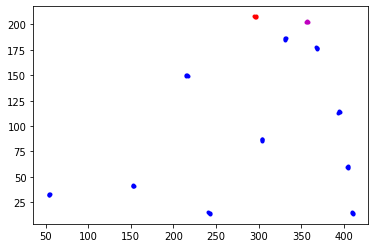

In [367]:
I = Fids.is_fif
plt.plot(Fids.x[I,:], Fids.y[I,:], 'b.')
#I = Fids.is_gif
#plt.plot(Fids.x[I,:], Fids.y[I,:], 'r.');
plt.plot(GIF1.x, GIF1.y, 'r.')
plt.plot(GIF2.x, GIF2.y, 'm.');

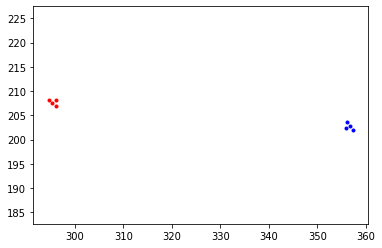

In [368]:
plt.plot(GIF1.x, GIF1.y, 'r.')
plt.plot(GIF2.x, GIF2.y, 'b.')
plt.axis('equal');

In [369]:
T = fits_table('gfa-metrology-transforms.fits')

In [425]:
Ti = T[T.gfa_num == gfa_num][0]

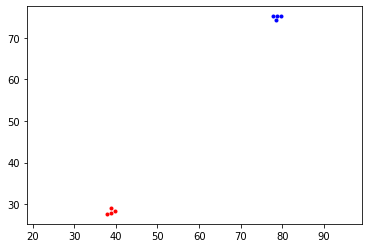

In [426]:
plt.plot(Ti.gif_1_mm_x, Ti.gif_1_mm_y, 'r.')
plt.plot(Ti.gif_2_mm_x, Ti.gif_2_mm_y, 'b.')
plt.axis('equal');

In [427]:
G1,G2 = GIF1,GIF2
v1 = np.array([np.mean(G1.x), np.mean(G1.y)])
v2 = np.array([np.mean(G2.x), np.mean(G2.y)])
vc = (v1 + v2) / 2.
dv = v2 - v1
p1 = np.array([np.mean(Ti.gif_1_mm_x), np.mean(Ti.gif_1_mm_y)])
p2 = np.array([np.mean(Ti.gif_2_mm_x), np.mean(Ti.gif_2_mm_y)])
pc = (p1 + p2) / 2.
dp = p2 - p1
th1 = np.arctan2(dv[1], dv[0])
th2 = np.arctan2(dp[1], dp[0])
dth = th2 - th1
R = np.array([[np.cos(dth), np.sin(dth)],[-np.sin(dth), np.cos(dth)]])
S = np.sqrt(np.sum(dv**2)) / np.sqrt(np.sum(dp**2))
M = np.zeros((2,3), np.float32)
M[:2,:2] = R * S
M[:,2] = vc
MI = np.zeros((2,3), np.float32)
MI[:2,:2] = R.T / S
MI[:,2] = pc

def gfa_mm_to_focal_mm(gfax, gfay):
    gfax = gfax.ravel()
    gfay = gfay.ravel()
    N = len(gfax)
    v = np.zeros((3,N))
    v[0,:] = gfax - pc[0]
    v[1,:] = gfay - pc[1]
    v[2,:] = 1.
    xy = np.matmul(M, v)
    return xy[0,:], xy[1,:]

def focal_mm_to_gfa_mm(x, y):
    x = x.ravel()
    y = y.ravel()
    N = len(x)
    v = np.zeros((3,N))
    v[0,:] = x - vc[0]
    v[1,:] = y - vc[1]
    v[2,:] = 1.
    xy = np.matmul(MI, v)
    return xy[0,:], xy[1,:]

def gfa_mm_to_gfa_pix(x, y):
    return (
        Ti.pix_x_coeffs[0] + Ti.pix_x_coeffs[1] * x + Ti.pix_x_coeffs[2] * y,
        Ti.pix_y_coeffs[0] + Ti.pix_y_coeffs[1] * x + Ti.pix_y_coeffs[2] * y)

def gfa_pix_to_gfa_mm(x, y):
    return (
        Ti.mm_x_coeffs[0] + Ti.mm_x_coeffs[1] * x + Ti.mm_x_coeffs[2] * y,
        Ti.mm_y_coeffs[0] + Ti.mm_y_coeffs[1] * x + Ti.mm_y_coeffs[2] * y)

def focal_mm_to_gfa_pix(x, y):
    gx,gy = focal_mm_to_gfa_mm(x, y)
    return gfa_mm_to_gfa_pix(gx, gy)

def gfa_pix_to_focal_mm(x, y):
    gx,gy = gfa_pix_to_gfa_mm(x, y)
    return gfa_mm_to_focal_mm(gx, gy)


In [433]:
g1x,g1y = gfa_mm_to_focal_mm(Ti.gif_1_mm_x, Ti.gif_1_mm_y)
g2x,g2y = gfa_mm_to_focal_mm(Ti.gif_2_mm_x, Ti.gif_2_mm_y)

In [434]:
w,h = 2048, 1032
ccdbx = np.array([0.5, 0.5, w+0.5, w+0.5, 0.5])
ccdby = np.array([0.5, h+0.5, h+0.5, 0.5, 0.5])
cbx,cby = gfa_pix_to_focal_mm(ccdbx, ccdby)

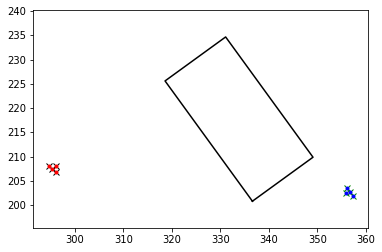

In [435]:
plt.plot(cbx, cby, 'k-')
plt.plot(g1x, g1y, 'kx')
plt.plot(G1.x, G1.y, 'r.')
plt.plot(g2x, g2y, 'gx')
plt.plot(G2.x, G2.y, 'b.')
plt.axis('equal');

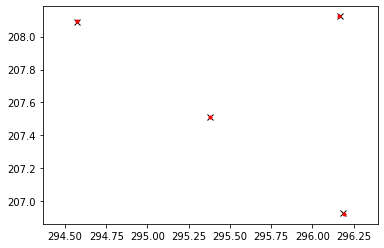

In [436]:
plt.plot(g1x, g1y, 'kx')
plt.plot(G1.x, G1.y, 'r.')
plt.axis('equal');

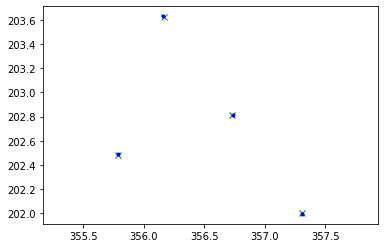

In [437]:
plt.plot(g2x, g2y, 'gx')
plt.plot(G2.x, G2.y, 'b.')
plt.axis('equal');

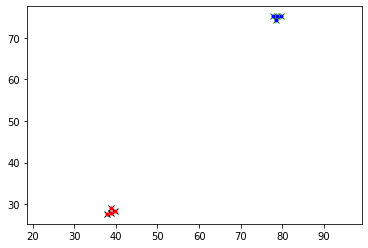

In [438]:
g1cx,g1cy = focal_mm_to_gfa_mm(G1.x, G1.y)
g2cx,g2cy = focal_mm_to_gfa_mm(G2.x, G2.y)
plt.plot(Ti.gif_1_mm_x, Ti.gif_1_mm_y, 'kx')
plt.plot(g1cx, g1cy, 'r.')
plt.plot(Ti.gif_2_mm_x, Ti.gif_2_mm_y, 'gx')
plt.plot(g2cx, g2cy, 'b.')
plt.axis('equal');

In [2]:
def parse_fif_metrology(ss, xyzcol=3):
    lines = ss.split('\n')
    # blocks of
    #   Device ID		Nutation	X	Y	Z
    #   11   FIF...  .
    #   __   FIF-1   .  x  y  z
    #   __   FIF-2   .  x  y  z
    #   __   FIF-3   .  x  y  z
    #   __   FIF-4   .  x  y  z
    locations = []
    device_id = None
    for line in lines:
        words = line.split('\t')
        if len(words[0]):
            device_id = int(words[0])
            #print('Start of device_id', device_id)
            continue
        fifname = words[1]
        x = float(words[xyzcol+0])
        y = float(words[xyzcol+1])
        z = float(words[xyzcol+2])
        locations.append((device_id, fifname, x, y, z))
        #print('Added', locations[-1])
    return locations

In [3]:
# DESI-4900-like petal metrology report
# Fiducial Locations		CAD Nominal - DESI-530				As Built Measured ABC Locations			
# Device ID		X	Y	Z	Nutation	X	Y	Z	Nutation*
petal10_ss = '''11	FIF - Nominal	54.182759	32.395574	-0.404797	0.558629	-	-	-	-
	FIF-1					53.53707378	31.67531386	-0.49039736	0
	FIF-2					53.59760823	33.2673462	-0.51567404	0
	FIF-3					54.16753503	32.44612536	-0.4959514	0
	FIF-4					54.798828	33.2236833	-0.52386702	0
75	FIF	153.098887	41.393265	-2.666555	1.468928	-	-	-	-
	FIF-1					152.216717	40.91941123	-2.73045012	2.5
	FIF-2					153.8155985	40.79885277	-2.76925636	2.5
	FIF-3					152.309935	42.11710443	-2.74139454	2.5
	FIF-4					153.0632278	41.4579716	-2.73779764	2.5
150	FIF - Nominal	241.627317	14.223609	-6.401469	2.438354	-	-	-	-
	FIF-1					242.3362464	13.59777436	-6.5733035	2.5
	FIF-2					241.5869121	14.25962724	-6.5391511	2.5
	FIF-3					242.4326801	14.79237046	-6.59222238	2.5
	FIF-4					240.8396335	14.9223488	-6.51606648	2.5
239	FIF - Nominal	215.603297	149.76275	-7.5611	2.721304	-	-	-	-
	FIF-1					216.5570119	149.5900592	-7.72826258	2.5
	FIF-2					215.0814469	148.9757457	-7.64567126	2.5
	FIF-3					215.5885014	149.8360882	-7.6754313	2.5
	FIF-4					214.6200293	150.0835711	-7.66948486	2.5
321	FIF - Nominal	304.144678	86.3733	-11.041361	3.59798	-	-	-	-
	FIF-1					304.2767854	87.43062162	-11.19632002	2.5
	FIF-2					304.0967435	86.4481306	-11.1447229	2.5
	FIF-3					303.2081456	86.89916092	-11.10996768	2.5
	FIF-4					303.9144193	85.46516166	-11.1248121	2.5
439	FIF - Nominal	409.474266	14.197003	-18.898949	5.938152	-	-	-	-
	FIF-1					410.0249639	13.50194832	-19.06526812	5
	FIF-2					408.8259474	15.09830668	-18.9427829	5
	FIF-3					409.4247104	14.30017418	-18.99669898	5
	FIF-4					410.3516814	14.65544312	-19.1324513	5
482	FIF - Nominal	404.225409	59.321591	-18.784086	5.899207	-	-	-	-
	FIF-1					403.2586227	59.63139484	-18.78808842	5
	FIF-2					404.2752017	58.40566104	-18.87215428	5
	FIF-3					404.1657397	60.40293576	-18.89902864	5
	FIF-4					404.221496	59.40499994	-18.87956606	5
496	FIF - Nominal	330.848478	185.657667	-16.056824	5.018809	-	-	-	-
	FIF-1					330.3591728	184.736043	-16.11667828	5
	FIF-2					330.1907792	186.3259628	-16.17344754	5
	FIF-3					330.8709126	185.59227	-16.18182028	5
	FIF-4					331.3798498	186.4489494	-16.27823776	5
517	FIF - Nominal	393.926712	113.390039	-18.918818	5.944905	-	-	-	-
	FIF-1					394.7998775	113.8930899	-19.15230482	5
	FIF-2					393.9121572	113.4362107	-19.02610196	5
	FIF-3					393.7226149	114.4173768	-19.05234244	5
	FIF-4					393.0295732	112.9794384	-18.9283685	5
534	FIF - Nominal	367.822967	176.645359	-18.733541	5.882117	-	-	-	-
	FIF-1					368.4114369	175.9801096	-18.8574913	5
	FIF-2					367.7372617	176.7209994	-18.81590146	5
	FIF-3					368.626061	177.1632083	-18.95653578	5
	FIF-4					367.0644185	177.4537401	-18.8012059	5
541	GIF - Nominal	295.568779	207.45146	-14.494325	5.361546	-	-	-	-
	GIF-1					296.1642755	208.1220476	-14.85529488	5
	GIF-2					294.5711798	208.0948506	-14.7114935	5
	GIF-3					296.1898129	206.9241777	-14.77474888	5
	GIF-4					295.3794394	207.5095688	-14.7288277	5
542	GIF - Nominal	357.223911	202.680763	-19.097053	5.361546	-	-	-	-
	GIF-1					357.3089606	201.9954298	-19.3228546	5
	GIF-2					356.7345915	202.8122636	-19.32597056	5
	GIF-3					356.1551442	203.6290222	-19.3597987	5
	GIF-4					355.7863529	202.4901489	-19.2501465	5'''

In [4]:
locs = parse_fif_metrology(petal10_ss, xyzcol=6)
gfanum = 5

In [5]:
locs

[(11, 'FIF-1', 53.53707378, 31.67531386, -0.49039736),
 (11, 'FIF-2', 53.59760823, 33.2673462, -0.51567404),
 (11, 'FIF-3', 54.16753503, 32.44612536, -0.4959514),
 (11, 'FIF-4', 54.798828, 33.2236833, -0.52386702),
 (75, 'FIF-1', 152.216717, 40.91941123, -2.73045012),
 (75, 'FIF-2', 153.8155985, 40.79885277, -2.76925636),
 (75, 'FIF-3', 152.309935, 42.11710443, -2.74139454),
 (75, 'FIF-4', 153.0632278, 41.4579716, -2.73779764),
 (150, 'FIF-1', 242.3362464, 13.59777436, -6.5733035),
 (150, 'FIF-2', 241.5869121, 14.25962724, -6.5391511),
 (150, 'FIF-3', 242.4326801, 14.79237046, -6.59222238),
 (150, 'FIF-4', 240.8396335, 14.9223488, -6.51606648),
 (239, 'FIF-1', 216.5570119, 149.5900592, -7.72826258),
 (239, 'FIF-2', 215.0814469, 148.9757457, -7.64567126),
 (239, 'FIF-3', 215.5885014, 149.8360882, -7.6754313),
 (239, 'FIF-4', 214.6200293, 150.0835711, -7.66948486),
 (321, 'FIF-1', 304.2767854, 87.43062162, -11.19632002),
 (321, 'FIF-2', 304.0967435, 86.4481306, -11.1447229),
 (321, 'FIF-

In [6]:
# DESI-4900-v1, FPP Metrology Traveler
petal4_ss = '''11	FIF - Nominal	0.558629	-	-	-
	FIF-1		54.99320684	31.66342124	-0.4832456
	FIF-2		54.66108038	33.22834094	-0.48150216
	FIF-3		53.8205475	31.41592892	-0.46692556
	FIF-4		54.24102252	32.32175516	-0.46346552
75	FIF	1.468928	-	-	-
	FIF-1		153.6655444	40.53854118	-2.76179524
	FIF-2		152.1792322	41.13017484	-2.73044028
	FIF-3		153.1447301	41.3911849	-2.70634114
	FIF-4		152.6233363	42.24702992	-2.7500575
150	FIF - Nominal	2.438354	-	-	-
	FIF-1		242.0584188	13.44506926	-6.52596054
	FIF-2		240.5745214	14.05297984	-6.4686484
	FIF-3		241.5454931	14.30400434	-6.48251838
	FIF-4		241.0287922	15.16329708	-6.49269392
239	FIF - Nominal	2.721304	-	-	-
	FIF-1		216.160398	149.040522	-7.6842387
	FIF-2		215.5298596	149.8197567	-7.67006476
	FIF-3		216.4487246	150.2080576	-7.73927368
	FIF-4		214.8969753	150.596674	-7.6932011
321	FIF - Nominal	3.59798	-	-	-
	FIF-1		303.5907464	85.55415992	-11.11969222
	FIF-2		305.0359665	86.23267124	-11.23974664
	FIF-3		303.0822399	86.64025808	-11.11163798
	FIF-4		304.0601071	86.43562262	-11.14626722
439	FIF - Nominal	5.938152	-	-	-
	FIF-1		409.5927299	13.2403604	-18.9921804
	FIF-2		409.3322864	14.2057119	-18.96055436
	FIF-3		410.3263092	14.18319856	-19.08722
	FIF-4		409.0730445	15.16975794	-18.9448229
482	FIF - Nominal	5.899207	-	-	-
	FIF-1		403.3506943	58.75264552	-18.77592004
	FIF-2		403.7968974	60.28564522	-18.85050358
	FIF-3		404.1463548	59.34724298	-18.86043072
	FIF-4		404.9422351	59.94678856	-18.97919554
496	FIF - Nominal	5.018809	-	-	-
	FIF-1		330.789483	184.7610689	-16.09504796
	FIF-2		331.7595591	186.0265571	-16.2543277
	FIF-3		329.8395886	185.4963188	-16.06336422
	FIF-4		330.7999302	185.7593643	-16.129651
517	FIF - Nominal	5.944905	-	-	-
	FIF-1		394.721569	112.9105187	-18.9725828
	FIF-2		394.0696699	114.3705027	-18.95131174
	FIF-3		393.6315725	112.4219632	-18.83310524
	FIF-4		393.8509971	113.3954651	-18.8806721
534	FIF - Nominal	5.882117	-	-	-
	FIF-1		368.3195078	175.8212253	-18.8337331
	FIF-2		367.7548072	176.68145	-18.81281684
	FIF-3		368.7116517	176.95468	-18.9406768
	FIF-4		367.2206515	177.5264103	-18.80629292
541	GIF - Nominal	5.361546	-	-	-
	GIF-1		295.3605812	206.2097342	-14.60754158
	GIF-2		294.2949159	207.4048371	-14.60875232
	GIF-3		295.2732336	207.2060213	-14.6438099
	GIF-4		295.1867222	208.2015807	-14.72795736
542	GIF - Nominal	5.361546	-	-	-
	GIF-1		356.8290036	201.7718	-19.23479474
	GIF-2		356.5695239	203.3503807	-19.30996078
	GIF-3		357.2882466	202.6556593	-19.31089874
	GIF-4		357.7477894	203.5378982	-19.43406316'''

In [7]:
locs = parse_fif_metrology(petal4_ss)
gfanum = 10

In [8]:
locs[-1]

(542, 'GIF-4', 357.7477894, 203.5378982, -19.43406316)

In [9]:
xyz = np.array([l[2:] for l in locs])
xyz.shape

(48, 3)

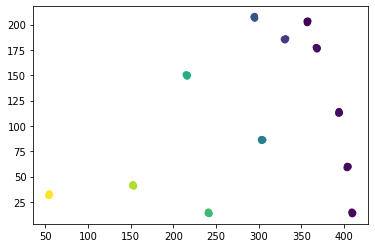

In [10]:
plt.scatter(xyz[:,0], xyz[:,1], c=xyz[:,2]);

In [11]:
dxyz = xyz - np.mean(xyz, axis=0)
U,S,V = np.linalg.svd(dxyz, full_matrices=False)

V0 = V[0,:]
V1 = V[1,:]
V2 = V[2,:]
if np.dot(np.cross(V0, V1), V2) < 0:
    V1 *= -1

v1 = np.dot(dxyz, V0)
v2 = np.dot(dxyz, V1)
v3 = np.dot(dxyz, V2)
print(S)

[754.97114375 458.58742494   8.88569737]


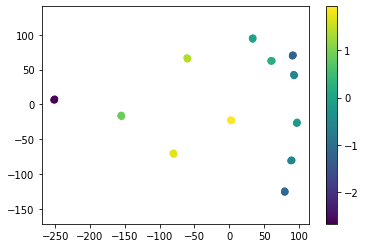

In [12]:
plt.scatter(v1, v2, c=v3)
plt.colorbar()
plt.axis('equal');

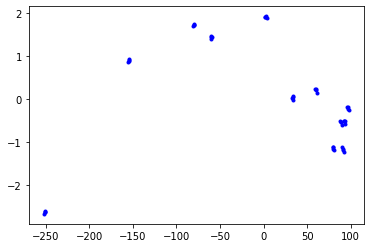

In [13]:
plt.plot(v1, v3, 'b.');

In [14]:
F = fits_table()
F.device = np.array([l[0] for l in locs])
F.name = np.array([l[1] for l in locs])
F.x = np.array([l[2] for l in locs])
F.y = np.array([l[3] for l in locs])
F.z = np.array([l[4] for l in locs])
F.xyz = np.array([l[2:] for l in locs])
F.v1 = v1
F.v2 = v2
F.isgif = np.array([name.startswith('GIF') for name in F.name])

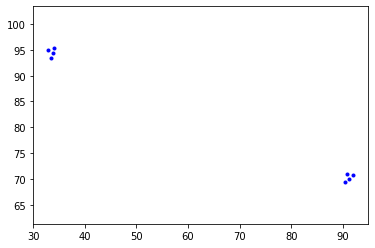

In [15]:
GIF = F[F.isgif]

plt.plot(GIF.v1, GIF.v2, 'b.')
plt.axis('equal');

In [16]:
T = fits_table('gfa-metrology-transforms.fits')

In [17]:
T.about()

tabledata object with 6 rows and 13 columns:
   gfa_num (<class 'numpy.ndarray'>) shape (6,) dtype uint8
   gif_1_mm_x (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_1_mm_y (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_1_pix_x (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_1_pix_y (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_2_mm_x (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_2_mm_y (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_2_pix_x (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   gif_2_pix_y (<class 'numpy.ndarray'>) shape (6, 4) dtype >f4
   mm_x_coeffs (<class 'numpy.ndarray'>) shape (6, 3) dtype >f4
   mm_y_coeffs (<class 'numpy.ndarray'>) shape (6, 3) dtype >f4
   pix_x_coeffs (<class 'numpy.ndarray'>) shape (6, 3) dtype >f4
   pix_y_coeffs (<class 'numpy.ndarray'>) shape (6, 3) dtype >f4


In [18]:
t = (T[(T.gfa_num == gfanum)])[0]
t.gfa_num

10

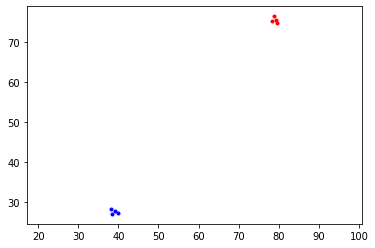

In [19]:
plt.plot(t.gif_1_mm_x, t.gif_1_mm_y, 'b.')
plt.plot(t.gif_2_mm_x, t.gif_2_mm_y, 'r.')
plt.axis('equal');

In [20]:
devids = np.unique(GIF.device)
assert(len(devids) == 2)
GIF1 = GIF[GIF.device == devids[0]]
GIF2 = GIF[GIF.device == devids[1]]

In [21]:
np.hypot(np.mean(GIF1.v1) - np.mean(GIF2.v1), np.mean(GIF1.v2) - np.mean(GIF2.v2))

62.40126241758099

In [22]:
np.sqrt(np.sum((np.mean(GIF1.xyz, axis=0) - np.mean(GIF2.xyz, axis=0))**2))

62.412764359540624

In [23]:
np.hypot(np.mean(t.gif_1_mm_x) - np.mean(t.gif_2_mm_x), np.mean(t.gif_1_mm_y) - np.mean(t.gif_2_mm_y))

62.45566

In [66]:
from focalplane_ss import focal_surface_ss

In [67]:
from scipy.interpolate import InterpolatedUnivariateSpline
                                               
rz = np.array([[float(w) for w in line.split('\t')] for line in focal_surface_ss.split('\n')])
Ropt,Zopt = rz[:,0], rz[:,1]
Zoptics = InterpolatedUnivariateSpline(Ropt, Zopt)

In [26]:
Ropt[-1], Ropt[-20], Zopt[-1], Zopt[-20]

(420.0, 401.0, -19.931676, -18.050405)

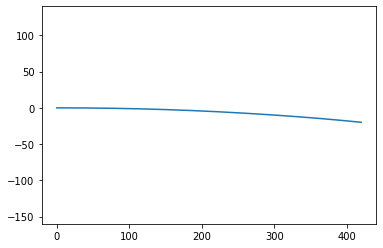

In [27]:
plt.plot(Ropt, Zopt)
plt.axis('equal');

In [28]:
Zoptics(np.hypot(GIF1.x, GIF1.y)), Zoptics(np.hypot(GIF2.x, GIF2.y))

(array([-14.41659003, -14.40120479, -14.45794909, -14.4995766 ]),
 array([-18.91923017, -18.97402678, -19.00189416, -19.08480707]))

In [29]:
GIF1.z, GIF2.z

(array([-14.60754158, -14.60875232, -14.6438099 , -14.72795736]),
 array([-19.23479474, -19.30996078, -19.31089874, -19.43406316]))

In [30]:
(GIF1.z - Zoptics(np.hypot(GIF1.x, GIF1.y)), GIF2.z - Zoptics(np.hypot(GIF2.x, GIF2.y)))

(array([-0.19095155, -0.20754753, -0.18586081, -0.22838076]),
 array([-0.31556457, -0.335934  , -0.30900458, -0.34925609]))

In [68]:
Spoly = np.array([9.95083E-06, 9.99997E-01, 1.79466E-07, 1.76983E-09,
         7.24320E-11, -5.74381E-13, 3.28356E-15, -1.10626E-17,
         1.89154E-20, -1.25367E-23])

In [69]:
radius = np.linspace(0, 420, 421)
S = np.zeros_like(radius)
for i,s in enumerate(Spoly):
    S += s * radius**i

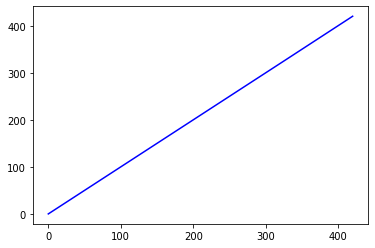

In [72]:
plt.plot(radius, S, 'b-');

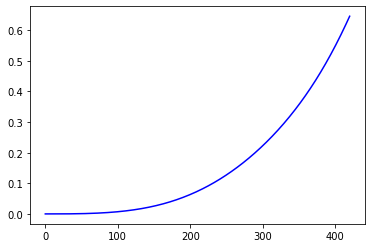

In [74]:
plt.plot(radius, S-radius, 'b-');

In [76]:
from platescale_ss import platescale_ss

In [113]:
psss = np.array([[float(w) for w in line.split('\t')] for line in platescale_ss.split('\n')])
Rps, Mps, Sps = psss[:,0], psss[:,6], psss[:,7]

Mpsfunc = InterpolatedUnivariateSpline(Rps, Mps)
Spsfunc = InterpolatedUnivariateSpline(Rps, Sps)

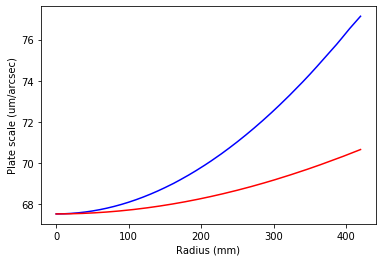

In [81]:
plt.plot(Rps, Mps, 'b-')
plt.plot(Rps, Sps, 'r-')
plt.xlabel('Radius (mm)')
plt.ylabel('Plate scale (um/arcsec)');

In [133]:
# Fit in arcsec/mm, not um/arcsec
Mangle = InterpolatedUnivariateSpline(Rps, 1000./Mps).antiderivative()

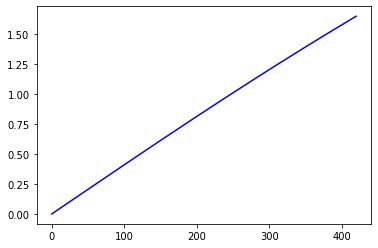

In [136]:
plt.plot(Rps, Mangle(Rps)/3600., 'b-');

In [82]:
gif1x, gif1y = 295.568779, 207.451460
gif2x, gif2y = 357.223911, 202.680763
gif1r = np.hypot(gif1x, gif1y)
gif2r = np.hypot(gif2x, gif2y)
gif1r, gif2r

(361.10526356684755, 410.7169515376716)

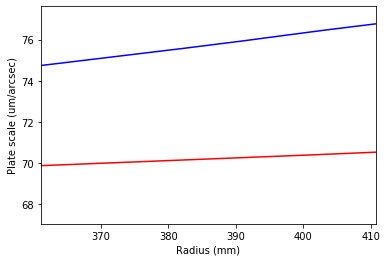

In [84]:
plt.plot(Rps, Mps, 'b-')
plt.plot(Rps, Sps, 'r-')
plt.xlabel('Radius (mm)')
plt.ylabel('Plate scale (um/arcsec)')
plt.xlim(gif1r, gif2r);

In [87]:
F.xyz[F.isgif]

array([[295.3605812 , 206.2097342 , -14.60754158],
       [294.2949159 , 207.4048371 , -14.60875232],
       [295.2732336 , 207.2060213 , -14.6438099 ],
       [295.1867222 , 208.2015807 , -14.72795736],
       [356.8290036 , 201.7718    , -19.23479474],
       [356.5695239 , 203.3503807 , -19.30996078],
       [357.2882466 , 202.6556593 , -19.31089874],
       [357.7477894 , 203.5378982 , -19.43406316]])

In [91]:
t.gif_1_mm_x, t.gif_1_mm_y

(array([38.302, 39.894, 38.184, 39.039], dtype=float32),
 array([27.098, 27.263, 28.301, 27.78 ], dtype=float32))

In [332]:
G = F[F.isgif]
G1 = G[:4]
G2 = G[4:]
va = np.array([np.mean(G1.x), np.mean(G1.y)])
vb = np.array([np.mean(G2.x), np.mean(G2.y)])
vc = (va + vb) / 2.
pa = np.array([np.mean(t.gif_1_mm_x), np.mean(t.gif_1_mm_y)])
pb = np.array([np.mean(t.gif_2_mm_x), np.mean(t.gif_2_mm_y)])
pc = (pa + pb) / 2.

th1 = np.arctan2(vb[1]-va[1], vb[0]-va[0])
th2 = np.arctan2(pb[1]-pa[1], pb[0]-pa[0])
dth = th1 - th2

R = np.array([[np.cos(dth), np.sin(dth)],[-np.sin(dth), np.cos(dth)]])

pj = np.vstack((t.gif_1_mm_x, t.gif_1_mm_y)).T
pk = np.vstack((t.gif_2_mm_x, t.gif_2_mm_y)).T
xy1 = np.dot(R.T, (pj-pc).T).T + vc
xy2 = np.dot(R.T, (pk-pc).T).T + vc


In [106]:
# gfa size (mountain)
h,w = 1032, 2048
pixx = np.array([1, 1, w, w, 1])
pixy = np.array([1, h, h, 1, 1])
ccdx = t.mm_x_coeffs[0] + t.mm_x_coeffs[1]*pixx + t.mm_x_coeffs[2]*pixy
ccdy = t.mm_y_coeffs[0] + t.mm_y_coeffs[1]*pixx + t.mm_y_coeffs[2]*pixy

p = np.vstack((ccdx, ccdy)).T
ccdxy = np.dot(R.T, (p-pc).T).T + vc

In [129]:
def gfa_pixel_to_focal_xy(pixx, pixy):
    ccdx = t.mm_x_coeffs[0] + t.mm_x_coeffs[1]*pixx + t.mm_x_coeffs[2]*pixy
    ccdy = t.mm_y_coeffs[0] + t.mm_y_coeffs[1]*pixx + t.mm_y_coeffs[2]*pixy
    p = np.vstack((ccdx, ccdy)).T
    ccdxy = np.dot(R.T, (p-pc).T).T + vc
    return ccdxy[:,0], ccdxy[:,1]

In [209]:
def focal_xy_to_gfa_pixel(x, y):
    #px = t.pix_x_coeffs[0] + t.pix_x_coeffs[1]*x + t.pix_x_coeffs[2]*y
    #py = t.pix_y_coeffs[0] + t.pix_y_coeffs[1]*x + t.pix_y_coeffs[2]*y
    #p = np.vstack((px, py)).T
    #pxy = np.dot(R, (p-vc).T).T + pc
    #return pxy[:,0], pxy[:,1]
    xy = np.vstack((x,y)).T
    xy = np.dot(R, (xy-vc).T).T + pc
    x = xy[:,0]
    y = xy[:,1]
    px = t.pix_x_coeffs[0] + t.pix_x_coeffs[1]*x + t.pix_x_coeffs[2]*y
    py = t.pix_y_coeffs[0] + t.pix_y_coeffs[1]*x + t.pix_y_coeffs[2]*y
    return px,py

In [214]:
gpx,gpy = focal_xy_to_gfa_pixel(G1.x, G1.y)

In [211]:
gpx,gpy

(array([1907.26892858, 2013.41676569, 1964.35432745, 2021.36774924]),
 array([-2020.91234659, -2031.42782726, -1986.52617113, -1952.12350201]))

In [212]:
gfa_pixel_to_focal_xy(gpx, gpy)

(array([295.3605847 , 294.29491948, 295.27323704, 295.18672558]),
 array([206.20974222, 207.40484507, 207.20602922, 208.20158853]))

In [213]:
G1.x, G1.y

(array([295.3605812, 294.2949159, 295.2732336, 295.1867222]),
 array([206.2097342, 207.4048371, 207.2060213, 208.2015807]))

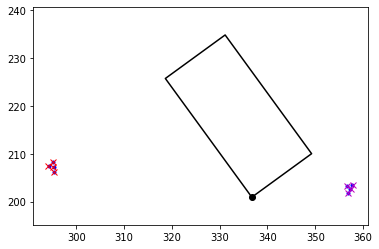

In [138]:
plt.plot(G.x, G.y, 'b.')
plt.plot(xy1[:,0], xy1[:,1], 'rx')
plt.plot(xy2[:,0], xy2[:,1], 'mx');
ccdx,ccdy = gfa_pixel_to_focal_xy(pixx, pixy)
plt.plot(ccdx, ccdy, 'k-')
plt.plot(ccdx[0], ccdy[0], 'ko')
plt.axis('equal');

In [176]:
ccdgridpx, ccdgridpy = np.meshgrid(np.linspace(-1000, 2100, 10), np.linspace(-2100, 1300, 10))
ccdgridpx = ccdgridpx.ravel()
ccdgridpy = ccdgridpy.ravel()
gridx, gridy = gfa_pixel_to_focal_xy(ccdgridpx, ccdgridpy)
gridr = np.hypot(gridx, gridy)
crpixx,crpixy = (w+1.)/2., (h+1.)/2.
crx,cry = gfa_pixel_to_focal_xy(crpixx, crpixy)

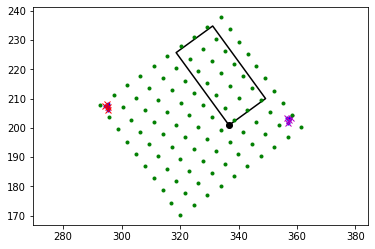

In [152]:
plt.plot(G.x, G.y, 'b.')
plt.plot(xy1[:,0], xy1[:,1], 'rx')
plt.plot(xy2[:,0], xy2[:,1], 'mx');
ccdx,ccdy = gfa_pixel_to_focal_xy(pixx, pixy)
plt.plot(ccdx, ccdy, 'k-')
plt.plot(ccdx[0], ccdy[0], 'ko')
plt.plot(gridx, gridy, 'g.')
plt.axis('equal');

In [159]:
gridr.max(), Rps.max()

(413.1234319298413, 420.0)

In [184]:
deflection = Mangle(gridr)/3600.
gridu = deflection * gridx / gridr
gridv = deflection * gridy / gridr
crr = np.hypot(crx, cry)
crd = Mangle(crr)/3600.
cru = crd * crx / crr
crv = crd * cry / crr

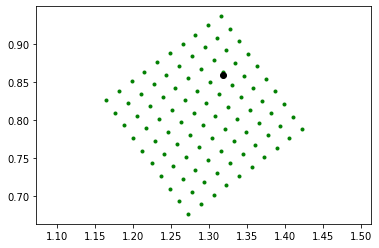

In [185]:
plt.plot(gridu, gridv, 'g.')
plt.plot(cru, crv, 'ko')
plt.axis('equal');

In [170]:
np.hypot(u[1]-u[0], v[1]-v[0]), np.hypot(u[10]-u[0], v[10]-v[0])

(0.02052613821028831, 0.02105035127573477)

In [195]:
from astrometry.util.util import fit_sip_coefficients, Tan, Sip, fit_sip_wcs_py
from astrometry.util.starutil_numpy import radectoxyz

In [223]:
griddec = gridv
gridra  = gridu / np.cos(np.deg2rad(griddec))
starxyz = radectoxyz(gridra, griddec)
fieldxy = np.vstack((ccdgridpx, ccdgridpy)).T
weights = np.ones(len(gridra))
nstars = len(gridra)
crdec = crv[0]
crra  = cru[0] / np.cos(np.deg2rad(crdec))
ps = 0.2/3600.
tan_in = Tan(crra, crdec, crpixx, crpixy, -ps, 0., 0., ps, float(w), float(h))
sip_order = 5
inv_order = 5
#sip_out = Sip()
#fit_sip_coefficients(starxyz, fieldxy, weights, nstars, tan_in, sip_order, inv_order, sip_out)
sip = fit_sip_wcs_py(starxyz, fieldxy, weights, tan_in, sip_order, inv_order)


In [224]:
sip.crval, crra, crdec

([1.3183189619304632, 0.8601277331043246],
 1.3183192248216404,
 0.8601279063074118)

In [225]:
sip.crpix, crpixx, crpixy

([1024.5, 516.5], 1024.5, 516.5)

In [226]:
sip.cd

(-3.467085510621358e-05,
 4.4064482462198546e-05,
 4.802329721520341e-05,
 3.235418941020604e-05)

In [239]:
np.linalg.svd(np.array(sip.cd).reshape((2,2)))

(array([[-0.54744926,  0.83683888],
        [ 0.83683888,  0.54744926]]),
 array([5.92418991e-05, 5.46550533e-05]),
 array([[ 0.99875759,  0.04983256],
        [-0.04983256,  0.99875759]]))

In [227]:
gpx1,gpy1 = focal_xy_to_gfa_pixel(G1.x, G1.y)
gpx2,gpy2 = focal_xy_to_gfa_pixel(G2.x, G2.y)

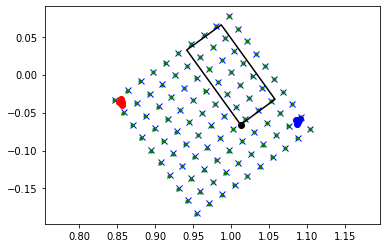

In [236]:
sip.crval = [1., 0.]
grx,gry = np.meshgrid(np.linspace(-1000, 2100, 10), np.linspace(-2100, 1300, 10))

gtr,gtd = sip.wcstan.pixelxy2radec(grx,gry)
plt.plot(gtr, gtd, 'bx')

grr,grd = sip.pixelxy2radec(grx,gry)
plt.plot(grr, grd, 'g.')

g1r,g1d = sip.pixelxy2radec(gpx1, gpy1)
g2r,g2d = sip.pixelxy2radec(gpx2, gpy2)
plt.plot(g1r, g1d, 'ro')
plt.plot(g2r, g2d, 'bo')
bra,bdec = sip.pixelxy2radec(pixx, pixy)
plt.plot(bra, bdec, 'k-')
plt.plot(bra[0], bdec[0], 'ko')
plt.axis('equal');

In [115]:
ccdr

array([392.1295483 , 407.53761454, 405.99086962, 390.52216839,
       392.1295483 ])

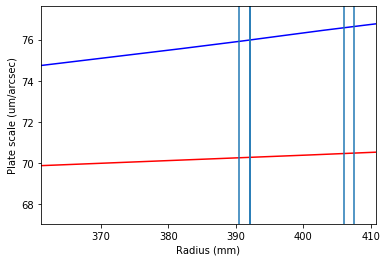

In [116]:
ccdx,ccdy = ccdxy[:,0],ccdxy[:,1]
ccdr = np.hypot(ccdx,ccdy)
plt.plot(Rps, Mps, 'b-')
plt.plot(Rps, Sps, 'r-')
plt.xlabel('Radius (mm)')
plt.ylabel('Plate scale (um/arcsec)')
plt.xlim(gif1r, gif2r);
ccdrmid = np.mean(ccdr[:4])
for r in ccdr:
    plt.axvline(r)


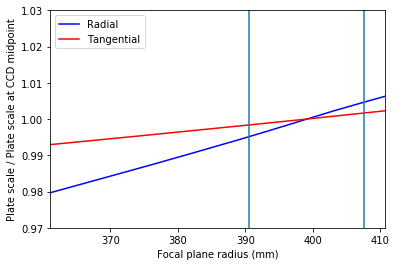

In [128]:
plt.plot(Rps, Mps / Mpsfunc(ccdrmid), 'b-', label='Radial')
plt.plot(Rps, Sps / Spsfunc(ccdrmid), 'r-', label='Tangential')
plt.legend()
plt.xlabel('Radius (mm)')
plt.ylabel('Plate scale / Plate scale at CCD midpoint')
plt.xlabel('Focal plane radius (mm)')
plt.xlim(gif1r, gif2r)
plt.axvline(min(ccdr))
plt.axvline(max(ccdr))
plt.ylim(0.97, 1.03);

In [127]:
0.02 * 30

0.6

In [31]:
r1 = np.mean(np.hypot(GIF1.x, GIF1.y))
r2 = np.mean(np.hypot(GIF2.x, GIF2.y))
# Eyeballed
rccd = 0.75*r2 + 0.25*r1

In [32]:
rccd, r1, r2

(398.1555514881337, 360.5514709546013, 410.6902449993111)

In [34]:
dz1 = Zoptics(r1, 1)
dz2 = Zoptics(r2, 1)
#dz1, dzc, dz2

In [35]:
z1 = Zoptics(r1)
z2 = Zoptics(r2)
zccd = Zoptics(rccd)
dzc = Zoptics(rccd, 1)

In [36]:
z1, z2, dzc, (r2-rccd)*dzc, z2-zccd, (r1-rccd)*dzc, z1-zccd, z2-z1

(array(-14.44379833),
 array(-18.99492919),
 array(-0.09487844),
 -1.1892721064243226,
 -1.2157668215310444,
 3.5678163192729837,
 3.335364040425384,
 -4.551130861956429)

In [37]:
(r1-rccd)*dzc - (r2-rccd)*dzc, z1-z2

(4.757088425697306, 4.551130861956429)

In [38]:
GIF1.z, GIF2.z

(array([-14.60754158, -14.60875232, -14.6438099 , -14.72795736]),
 array([-19.23479474, -19.30996078, -19.31089874, -19.43406316]))

In [39]:
((r2-rccd)*dzc) - (z2-zccd)

0.026494715106721856

In [40]:
((r1-rccd)*dzc) - (z1-zccd)

0.23245227884759956

In [41]:
#va = np.array([np.mean(GIF1.v1), np.mean(GIF1.v2)])
#vb = np.array([np.mean(GIF2.v1), np.mean(GIF2.v2)])
#vf = np.vstack((GIF1.v1, GIF1.v2)).T
#vg = np.vstack((GIF2.v1, GIF2.v2)).T
#vh = np.vstack((F.v1, F.v2)).T

va = np.array([np.mean(GIF1.x), np.mean(GIF1.y)])
vb = np.array([np.mean(GIF2.x), np.mean(GIF2.y)])
vf = np.vstack((GIF1.x, GIF1.y)).T
vg = np.vstack((GIF2.x, GIF2.y)).T
vh = np.vstack((F.x, F.y)).T

vc = (va + vb) / 2.

pa = np.array([np.mean(t.gif_1_mm_x), np.mean(t.gif_1_mm_y)])
pb = np.array([np.mean(t.gif_2_mm_x), np.mean(t.gif_2_mm_y)])
pc = (pa + pb) / 2.

th1 = np.arctan2(vb[1]-va[1], vb[0]-va[0])
th2 = np.arctan2(pb[1]-pa[1], pb[0]-pa[0])
dth = th1-th2

R = np.array([[np.cos(dth), np.sin(dth)],[-np.sin(dth), np.cos(dth)]])
vd = va - vc
td = np.dot(R, vd) + pc
ve = vb - vc
te = np.dot(R, ve) + pc

tf = np.dot(R, (vf-vc).T).T + pc
tg = np.dot(R, (vg-vc).T).T + pc

ph = np.vstack((t.gif_1_mm_x, t.gif_1_mm_y)).T
pi = np.vstack((t.gif_2_mm_x, t.gif_2_mm_y)).T

th = np.dot(R, (vh-vc).T).T + pc

In [ ]:
vh = np.vstack((F.x, F.y)).T
th = np.dot(R, (vh-vc).T).T + pc

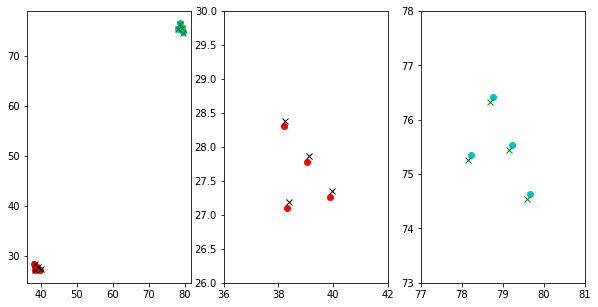

In [42]:
plt.figure(figsize=(10,5))
plt.clf()
for i,ax in enumerate([None, (36,42,26,30), (77,81,73,78)]):
    plt.subplot(1,3,i+1)
    #plt.plot(pa[0],pa[1],'rx')
    plt.plot(ph[:,0], ph[:,1], 'ro')
    #plt.plot(pb[0],pb[1],'bx')
    #if i == 1:
    #    for j in range(4):
    #        plt.text(ph[j,0], ph[j,1], '%i'%j, ha='right')

    plt.plot(pi[:,0], pi[:,1], 'co')

    #plt.plot(pd[0],pd[1], 'go')
    #plt.plot(pe[0],pe[1], 'mo')
    plt.plot(tf[:,0], tf[:,1], 'kx')
    #if i == 1:
    #    for j in range(4):
    #        plt.text(tf[j,0], tf[j,1], '%i'%j, ha='left')

    plt.plot(tg[:,0], tg[:,1], 'gx')

    #plt.axis('equal')
    if ax is not None:
        plt.axis(ax)

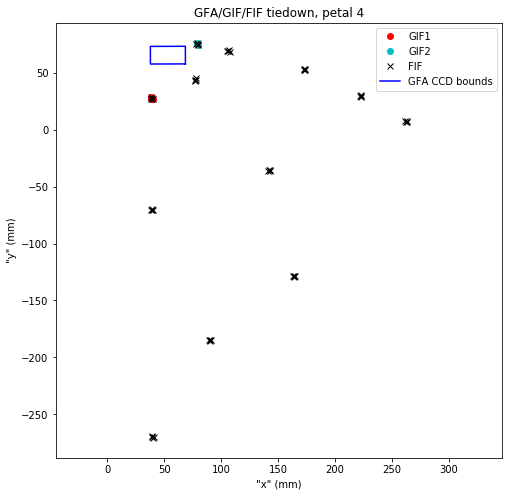

In [43]:
plt.figure(figsize=(8,8))
plt.clf()

# gfa size (mountain)
h,w = 1032, 2048
pixx = np.array([1, 1, w, w, 1])
pixy = np.array([1, h, h, 1, 1])
ccdx = t.mm_x_coeffs[0] + t.mm_x_coeffs[1]*pixx + t.mm_x_coeffs[2]*pixy
ccdy = t.mm_y_coeffs[0] + t.mm_y_coeffs[1]*pixx + t.mm_y_coeffs[2]*pixy

plt.plot(ph[:,0], ph[:,1], 'ro', label='GIF1')
plt.plot(pi[:,0], pi[:,1], 'co', label='GIF2')
plt.plot(th[:,0], th[:,1], 'kx', label='FIF');
plt.plot(ccdx, ccdy, 'b-', label='GFA CCD bounds')
plt.legend()
plt.axis('equal');
plt.xlabel('"x" (mm)')
plt.ylabel('"y" (mm)')
plt.title('GFA/GIF/FIF tiedown, petal 4')
plt.savefig('/tmp/1.png')

In [44]:
# DESI-0530-v16 -- focal plane layout
#device_location_id	device_type	X	Y	Z
design_ss = '''0	POS	28.134375	5.201437	-0.082419
1	POS	38.551296	5.201448	-0.152664
2	POS	33.343493	14.253354	-0.132583
3	POS	48.968106	5.201461	-0.245266
4	POS	43.760371	14.255653	-0.214058
5	POS	59.384810	5.201480	-0.360537
6	POS	54.177144	14.256291	-0.318053
7	POS	48.967142	23.345351	-0.298069
8	POS	69.800289	5.201506	-0.498824
9	POS	64.592763	14.249463	-0.444873
10	POS	59.383858	23.337718	-0.413611
11	FIF	54.182759	32.395574	-0.404797
12	POS	80.215689	5.201540	-0.660539
13	POS	75.008287	14.241437	-0.594928
14	POS	69.800405	23.299254	-0.552079
15	POS	64.599448	32.359504	-0.531959
16	POS	90.630976	5.201583	-0.846101
17	POS	85.423703	14.236912	-0.768639
18	POS	80.215599	23.295915	-0.714161
19	POS	75.016034	32.323704	-0.682426
20	POS	69.786205	41.395803	-0.673227
21	POS	101.046105	5.201632	-1.055932
22	POS	95.838980	14.237022	-0.966431
23	POS	90.630637	23.299708	-0.900149
24	POS	85.432557	32.329622	-0.856874
25	POS	80.200656	41.359380	-0.835814
26	POS	111.461023	5.201688	-1.290443
27	POS	106.254079	14.235969	-1.188700
28	POS	101.045606	23.296309	-1.110389
29	POS	95.848134	32.326855	-1.055354
30	POS	90.614980	41.368525	-1.022718
31	POS	85.361306	50.431334	-1.012965
32	POS	121.875677	5.201751	-1.550013
33	POS	116.668954	14.238986	-1.435858
34	POS	111.460452	23.297031	-1.345338
35	POS	106.263304	32.326987	-1.278351
36	POS	101.029161	41.366600	-1.233845
37	POS	95.776854	50.441734	-1.212562
38	NON	90.539726	59.568980	-1.215569
39	POS	132.290020	5.201820	-1.834975
40	POS	127.083563	14.242436	-1.708249
41	POS	121.875109	23.312745	-1.605420
42	POS	116.677631	32.345810	-1.526342
43	POS	111.443232	41.368033	-1.469701
44	POS	106.192152	50.442824	-1.436591
45	POS	100.955815	59.573706	-1.428027
46	POS	142.704022	5.201895	-2.145600
47	POS	137.497877	14.241743	-2.006158
48	POS	132.289546	23.328109	-1.890884
49	POS	127.093215	32.371519	-1.799643
50	POS	121.857174	41.401574	-1.730894
51	POS	116.607190	50.444640	-1.685510
52	POS	111.371701	59.574862	-1.665163
53	POS	106.147709	68.622231	-1.667694
54	POS	153.117665	5.201978	-2.482086
55	POS	147.911879	14.235958	-2.329817
56	POS	142.703742	23.330238	-2.201928
57	POS	137.506269	32.376499	-2.098242
58	POS	132.271120	41.413641	-2.017254
59	POS	127.021981	50.454549	-1.959713
60	POS	121.787408	59.563824	-1.927184
61	POS	116.563412	68.623975	-1.918115
62	POS	163.530944	5.202069	-2.844554
63	POS	158.325567	14.241167	-2.679433
64	POS	153.117660	23.321177	-2.538751
65	POS	147.918667	32.352849	-2.422347
66	POS	142.685037	41.415900	-2.329129
67	POS	137.436514	50.486772	-2.259620
68	POS	132.202886	59.588974	-2.214985
69	POS	126.978911	68.612156	-2.193495
70	POS	121.778363	77.687710	-2.197208
71	POS	173.943870	5.202169	-3.233037
72	POS	168.738956	14.240451	-3.055031
73	POS	163.531281	23.302369	-2.901472
74	POS	158.330800	32.347757	-2.772446
75	FIF	153.098887	41.393265	-2.666555
76	POS	147.850932	50.487573	-2.584842
77	POS	142.618180	59.596960	-2.528094
78	POS	137.394166	68.637151	-2.494814
79	POS	132.194081	77.680593	-2.486192
80	POS	184.356463	5.202278	-3.647476
81	POS	179.152070	14.237881	-3.456608
82	POS	173.944624	23.313286	-3.290323
83	POS	168.742846	32.358998	-3.148597
84	POS	163.512702	41.389721	-3.030031
85	POS	158.265131	50.453724	-2.935460
86	POS	153.033251	59.588635	-2.866668
87	POS	147.809242	68.640326	-2.821366
88	POS	142.609571	77.685414	-2.800809
89	POS	137.409794	86.716472	-2.803969
90	POS	194.768763	5.202397	-4.087734
91	POS	189.564948	14.231336	-3.884058
92	POS	184.357651	23.280410	-3.704860
93	POS	179.154623	32.342155	-3.550453
94	POS	173.926432	41.409409	-3.419611
95	POS	168.679209	50.459776	-3.312354
96	POS	163.448048	59.556355	-3.230675
97	POS	158.224107	68.634312	-3.173432
98	POS	153.024816	77.664324	-3.140525
99	POS	147.825218	86.706198	-3.131882
100	POS	142.616722	95.751246	-3.147111
101	POS	205.180829	5.202527	-4.553598
102	POS	199.977654	14.228149	-4.337229
103	POS	194.770456	23.256961	-4.145219
104	POS	189.566012	32.307850	-3.977977
105	POS	184.340094	41.387352	-3.834629
106	POS	179.093132	50.462417	-3.715005
107	POS	173.862650	59.551524	-3.620789
108	POS	168.638734	68.605303	-3.550822
109	POS	163.439840	77.654626	-3.506024
110	POS	158.240184	86.685466	-3.485072
111	POS	153.031586	95.726599	-3.488175
112	POS	215.592744	5.202667	-5.044797
113	POS	210.390253	14.233781	-4.815894
114	POS	205.183093	23.257197	-4.611264
115	POS	199.977245	32.285080	-4.431206
116	POS	194.753631	41.348039	-4.275158
117	POS	189.506912	50.462612	-4.143312
118	POS	184.277019	59.546670	-4.036566
119	POS	179.053197	68.607518	-3.954311
120	POS	173.854426	77.638308	-3.896961
121	POS	168.655095	86.670127	-3.863853
122	POS	163.446281	95.705959	-3.854716
123	POS	158.248634	104.741309	-3.870224
124	POS	226.004616	5.202820	-5.561013
125	POS	220.802775	14.229185	-5.319695
126	POS	215.595622	23.261744	-5.102621
127	POS	210.388311	32.317634	-4.910212
128	POS	205.167155	41.341782	-4.741456
129	POS	199.920516	50.426528	-4.596705
130	POS	194.691621	59.521908	-4.477607
131	POS	189.467524	68.577093	-4.382801
132	POS	184.268924	77.622912	-4.313382
133	POS	179.069504	86.655195	-4.268042
134	POS	173.860831	95.690899	-4.246718
135	POS	168.663659	104.721625	-4.250040
136	POS	236.416418	5.202984	-6.101909
137	POS	231.215143	14.228888	-5.848342
138	POS	226.008091	23.252494	-5.618881
139	POS	220.799357	32.296346	-5.413915
140	POS	215.580565	41.367331	-5.233235
141	POS	210.334018	50.389100	-5.075337
142	POS	205.105538	59.491820	-4.943851
143	POS	199.882451	68.552724	-4.836730
144	POS	194.682930	77.592933	-4.754841
145	POS	189.483958	86.638469	-4.697482
146	POS	184.275264	95.675817	-4.663955
147	POS	179.078456	104.707107	-4.655151
148	POS	173.885775	113.739788	-4.670876
149	POS	246.838139	5.203163	-6.667712
150	FIF	241.627317	14.223609	-6.401469
151	POS	236.420299	23.253682	-6.159827
152	POS	231.210442	32.278714	-5.942410
153	POS	225.994948	41.335119	-5.749412
154	POS	220.747479	50.412015	-5.579621
155	POS	215.519290	59.455303	-5.435037
156	POS	210.296516	68.523290	-5.315623
157	POS	205.096945	77.569992	-5.221518
158	POS	199.897878	86.608920	-5.151744
159	POS	194.689627	95.659188	-5.106229
160	POS	189.493000	104.691658	-5.085266
161	POS	184.300546	113.724981	-5.088871
162	POS	179.106358	122.756412	-5.116722
163	POS	257.252581	5.203355	-7.257219
164	POS	252.044444	14.225931	-6.979102
165	POS	246.832142	23.247567	-6.725043
166	POS	241.621641	32.280091	-6.495493
167	POS	236.409626	41.304861	-6.290191
168	POS	231.161858	50.379780	-6.107991
169	POS	225.932910	59.445972	-5.951322
170	POS	220.710026	68.489860	-5.819230
171	POS	215.510811	77.540650	-5.712918
172	POS	210.312055	86.586048	-5.631009
173	POS	205.104645	95.629603	-5.573119
174	POS	199.907269	104.672739	-5.540138
175	POS	194.715187	113.707386	-5.531610
176	POS	189.520745	122.739141	-5.547294
177	POS	267.667769	5.203564	-7.870659
178	POS	262.457076	14.223228	-7.580439
179	POS	257.245228	23.248210	-7.314422
180	POS	252.034981	32.272538	-7.072788
181	POS	246.822518	41.305017	-6.855427
182	POS	241.576687	50.349591	-6.660775
183	POS	236.347185	59.413428	-6.491778
184	POS	231.128043	68.474233	-6.347859
185	POS	225.924551	77.507637	-6.228817
186	POS	220.726030	86.556806	-6.134746
187	POS	215.518882	95.606560	-6.064743
188	POS	210.321473	104.643918	-6.019405
189	POS	205.129745	113.686869	-5.998894
190	POS	199.935558	122.719129	-6.002410
191	POS	194.744335	131.752958	-6.030497
192	POS	278.094967	5.203789	-8.508655
193	POS	272.880840	14.222591	-8.206283
194	POS	267.662804	23.247127	-7.927934
195	POS	262.450433	32.272277	-7.674202
196	POS	257.238503	41.294646	-7.444760
197	POS	251.993690	50.347747	-7.238108
198	POS	246.762246	59.383505	-7.056492
199	POS	241.542032	68.441362	-6.900271
200	POS	236.339412	77.492988	-6.769400
201	POS	231.139839	86.523335	-6.662744
202	POS	225.930951	95.573444	-6.580426
203	POS	220.735635	104.618025	-6.523143
204	POS	215.544261	113.658685	-6.490394
205	POS	210.350327	122.700956	-6.481986
206	POS	205.159459	131.735505	-6.497923
207	POS	288.520497	5.204032	-9.170480
208	POS	283.299843	14.229781	-8.855715
209	POS	278.079780	23.248036	-8.565241
210	POS	272.860653	32.273705	-8.299135
211	POS	267.649767	41.298301	-8.057807
212	POS	262.411205	50.331000	-7.839225
213	POS	257.182799	59.378796	-7.645829
214	POS	251.957037	68.411117	-7.476803
215	POS	246.753235	77.459791	-7.333682
216	POS	241.554656	86.509371	-7.215298
217	POS	236.346852	95.544478	-7.120554
218	POS	231.149812	104.586756	-7.050948
219	POS	225.958811	113.631634	-7.006136
220	POS	220.765092	122.670975	-6.985460
221	POS	215.574184	131.715951	-6.989494
222	POS	210.382581	140.750850	-7.017600
223	POS	298.953468	5.204294	-9.857001
224	POS	293.728561	14.218382	-9.529742
225	POS	288.505535	23.257544	-9.227068
226	POS	283.281475	32.275235	-8.948564
227	POS	278.067188	41.301079	-8.695034
228	POS	272.827144	50.336734	-8.464336
229	POS	267.600450	59.355858	-8.258622
230	POS	262.380923	68.406696	-8.078133
231	POS	257.168712	77.430867	-7.922044
232	POS	251.967640	86.476933	-7.791341
233	POS	246.762098	95.530283	-7.684954
234	POS	241.563171	104.560869	-7.602848
235	POS	236.373441	113.597456	-7.545742
236	POS	231.179947	122.643407	-7.513065
237	POS	225.989315	131.685151	-7.504825
238	POS	220.798536	140.727742	-7.521000
239	FIF	215.603297	149.762750	-7.561100
240	POS	309.394888	5.204578	-10.568833
241	POS	304.165392	14.217045	-10.228797
242	POS	298.933687	23.243163	-9.913162
243	POS	293.710750	32.275395	-9.622605
244	POS	288.488660	41.300648	-9.356448
245	POS	283.262855	50.323803	-9.114380
246	POS	278.029621	59.359249	-8.896349
247	POS	272.801211	68.375285	-8.702714
248	POS	267.589952	77.423349	-8.534976
249	POS	262.380822	86.446658	-8.391294
250	POS	257.175223	95.496859	-8.272705
251	POS	251.987934	104.541895	-8.179454
252	POS	246.787326	113.571952	-8.109454
253	POS	241.594950	122.609516	-8.064452
254	POS	236.404576	131.653657	-8.044111
255	POS	231.216804	140.694437	-8.048185
256	POS	226.028648	149.734666	-8.076585
257	POS	319.850121	5.204885	-11.307161
258	POS	314.612103	14.217002	-10.953653
259	POS	309.378502	23.237608	-10.625208
260	POS	304.147696	32.261157	-10.321578
261	POS	298.923722	41.293825	-10.043004
262	POS	293.694739	50.321298	-9.788509
263	POS	288.474419	59.345236	-9.558944
264	POS	283.240527	68.372772	-9.352929
265	POS	278.012139	77.388951	-9.171448
266	POS	272.809994	86.429959	-9.016376
267	POS	267.593405	95.455660	-8.884476
268	POS	262.401352	104.508495	-8.778994
269	POS	257.211709	113.548234	-8.697715
270	POS	252.014008	122.580228	-8.640111
271	POS	246.820044	131.619729	-8.607269
272	POS	241.633103	140.662841	-8.599280
273	POS	236.444935	149.703018	-8.615484
274	POS	231.256874	158.743266	-8.656044
275	POS	330.318532	5.205216	-12.073034
276	POS	325.078996	14.216518	-11.705999
277	POS	319.828921	23.235072	-11.363253
278	POS	314.595961	32.254673	-11.046598
279	POS	309.365682	41.280926	-10.754879
280	POS	304.135730	50.314371	-10.487863
281	POS	298.912497	59.340436	-10.245747
282	POS	293.686595	68.356517	-10.027751
283	POS	288.459291	77.376609	-9.834108
284	POS	283.236538	86.392020	-9.665035
285	POS	278.024213	95.437310	-9.521578
286	POS	272.821097	104.465024	-9.402689
287	POS	267.630443	113.512587	-9.309372
288	POS	262.441442	122.550130	-9.240250
289	POS	257.245276	131.585800	-9.194988
290	POS	252.057751	140.623250	-9.174607
291	POS	246.867458	149.670397	-9.178725
292	POS	241.677540	158.713293	-9.207083
293	POS	340.797188	5.205575	-12.867597
294	POS	335.552207	14.218306	-12.486083
295	POS	330.298035	23.224970	-12.129266
296	POS	325.054239	32.249735	-11.798497
297	POS	319.819860	41.272437	-11.493384
298	POS	314.589074	50.294871	-11.213326
299	POS	309.371478	59.320811	-10.958902
300	POS	304.150100	68.340233	-10.728680
301	POS	298.925421	77.362295	-10.522758
302	POS	293.676715	86.384136	-10.339693
303	POS	288.453718	95.402776	-10.182688
304	POS	283.254608	104.435641	-10.051900
305	POS	278.057515	113.471479	-9.945668
306	POS	272.870897	122.512376	-9.864567
307	POS	267.682215	131.551279	-9.807628
308	POS	262.490887	140.589317	-9.774842
309	POS	257.291318	149.636802	-9.766236
310	POS	252.099270	158.687269	-9.782557
311	POS	246.917324	167.729911	-9.823532
312	POS	351.280618	5.205963	-13.691992
313	POS	346.034733	14.214559	-13.295560
314	POS	340.778866	23.232078	-12.924261
315	POS	335.530289	32.234896	-12.579013
316	POS	330.285806	41.261496	-12.259553
317	POS	325.050884	50.288478	-11.965927
318	POS	319.828324	59.302608	-11.697953
319	POS	314.601034	68.336209	-11.454655
320	POS	309.373021	77.352030	-11.235694
321	FIF	304.144678	86.373300	-11.041361
322	POS	298.918599	95.390299	-10.871596
323	POS	293.697158	104.410906	-10.726660
324	POS	288.499421	113.443777	-10.607980
325	POS	283.304821	122.479109	-10.513948
326	POS	278.114386	131.526696	-10.444905
327	POS	272.923365	140.568834	-10.400054
328	POS	267.728162	149.605054	-10.379125
329	POS	262.526411	158.657932	-10.382758
330	POS	257.345257	167.706617	-10.411861
331	NON	252.162106	176.750314	-10.465030
332	POS	361.783127	5.206384	-14.549105
333	POS	356.530930	14.220045	-14.136500
334	POS	351.271491	23.232906	-13.749722
335	POS	346.019309	32.245241	-13.389574
336	POS	340.768571	41.247595	-13.055163
337	POS	335.525469	50.277241	-12.747047
338	POS	330.294391	59.301199	-12.465020
339	POS	325.070982	68.316073	-12.208444
340	POS	319.851287	77.335954	-11.977046
341	POS	314.623303	86.355671	-11.769773
342	POS	309.393767	95.374515	-11.587014
343	POS	304.167566	104.400012	-11.429209
344	POS	298.948599	113.421707	-11.296325
345	POS	293.750911	122.455935	-11.189651
346	POS	288.553193	131.494549	-11.107533
347	POS	283.363186	140.541106	-11.050585
348	POS	278.169146	149.589855	-11.017886
349	POS	272.969703	158.626925	-11.008879
350	POS	267.784582	167.675147	-11.025557
351	POS	262.605756	176.725473	-11.067107
352	POS	372.304572	5.206842	-15.440826
353	POS	367.046904	14.222657	-15.011204
354	POS	361.784479	23.239621	-14.608186
355	POS	356.519189	32.251191	-14.231495
356	POS	351.267336	41.266855	-13.882142
357	POS	346.014080	50.267603	-13.558386
358	POS	340.775422	59.295836	-13.261679
359	POS	335.555016	68.318525	-12.991660
360	POS	330.326002	77.329411	-12.745911
361	POS	325.099923	86.353919	-12.525580
362	POS	319.868254	95.368418	-12.329484
363	POS	314.637249	104.387907	-12.158275
364	POS	309.427165	113.415438	-12.013390
365	POS	304.208643	122.438262	-11.892373
366	POS	299.007270	131.474777	-11.797446
367	POS	293.812414	140.513049	-11.727514
368	POS	288.618081	149.564277	-11.682528
369	POS	283.434521	158.608349	-11.662486
370	POS	278.235112	167.644897	-11.665619
371	POS	273.048024	176.699716	-11.694696
372	POS	267.869980	185.752885	-11.748763
373	POS	382.851708	5.207341	-16.369647
374	POS	377.581275	14.225697	-15.921480
375	POS	372.310360	23.245507	-15.500886
376	POS	367.036487	32.265703	-15.107224
377	POS	361.774214	41.273042	-14.741197
378	POS	356.521510	50.285321	-14.402351
379	POS	351.271943	59.289571	-14.089663
380	POS	346.050117	68.310962	-13.805129
381	POS	340.826055	77.330498	-13.545841
382	POS	335.598169	86.342713	-13.311368
383	POS	330.367518	95.360056	-13.101863
384	POS	325.135653	104.372163	-12.917097
385	POS	319.908601	113.396362	-12.757811
386	POS	314.691225	122.433475	-12.624339
387	POS	309.471704	131.456899	-12.515035
388	POS	304.271509	140.492776	-12.432075
389	POS	299.077457	149.538764	-12.374455
390	POS	293.895890	158.584419	-12.342237
391	POS	288.714729	167.629767	-12.334575
392	POS	283.515091	176.664566	-12.349843
393	POS	278.343637	185.717251	-12.392174
394	POS	393.424937	5.207884	-17.337325
395	POS	388.140778	14.229285	-16.869737
396	POS	382.863296	23.247053	-16.430889
397	POS	377.591794	32.264029	-16.020274
398	POS	372.323203	41.277959	-15.637166
399	POS	367.059580	50.285702	-15.281291
400	POS	361.805862	59.294163	-14.952744
401	POS	356.557594	68.302202	-14.650789
402	POS	351.332946	77.326055	-14.376874
403	POS	346.106481	86.351068	-14.128452
404	POS	340.874021	95.367865	-13.904804
405	POS	335.640990	104.385298	-13.706357
406	POS	330.406184	113.397881	-13.532738
407	POS	325.172714	122.420562	-13.384453
408	POS	319.951289	131.457285	-13.262356
409	POS	314.740071	140.488302	-13.165650
410	POS	309.544573	149.527366	-13.095060
411	POS	304.359611	158.566940	-13.049907
412	POS	299.178985	167.613923	-13.029974
413	POS	293.998533	176.660957	-13.034708
414	POS	288.801639	185.695643	-13.062499
415	POS	283.637442	194.747780	-13.117824
416	POS	404.081201	5.208477	-18.350559
417	POS	398.738956	14.225389	-17.858705
418	POS	393.449077	23.249638	-17.400470
419	POS	388.167805	32.268975	-16.971185
420	POS	382.890716	41.283512	-16.570017
421	POS	377.618145	50.294466	-16.196593
422	POS	372.348713	59.303226	-15.850413
423	POS	367.092929	68.311732	-15.532043
424	POS	361.850852	77.323843	-15.241188
425	POS	356.626281	86.349467	-14.978049
426	POS	351.396985	95.375716	-14.740313
427	POS	346.159685	104.396074	-14.527379
428	POS	340.921924	113.416595	-14.339816
429	POS	335.673666	122.435172	-14.176645
430	POS	330.441604	131.452755	-14.039819
431	POS	325.231465	140.491382	-13.930301
432	POS	320.024196	149.522514	-13.845693
433	POS	314.833968	158.562743	-13.787499
434	POS	309.652699	167.606302	-13.754882
435	POS	304.467332	176.653076	-13.746898
436	POS	299.297680	185.703512	-13.764947
437	POS	294.103927	194.734795	-13.805322
438	NON	288.953309	203.790235	-13.874466
439	FIF	409.474266	14.197003	-18.898949
440	POS	404.122544	23.218728	-18.415962
441	POS	398.819158	32.244354	-17.966249
442	POS	393.534784	41.265881	-17.546494
443	POS	388.254349	50.281413	-17.154860
444	POS	382.975029	59.289875	-16.790698
445	POS	377.695835	68.298438	-16.453664
446	POS	372.431600	77.312536	-16.144837
447	POS	367.188181	86.331367	-15.864379
448	POS	361.959983	95.356349	-15.611525
449	POS	356.724409	104.385028	-15.384085
450	POS	351.492977	113.402714	-15.182459
451	POS	346.256488	122.421077	-15.005980
452	POS	341.024728	131.441075	-14.855323
453	POS	335.785391	140.454435	-14.729134
454	POS	330.586206	149.495602	-14.632116
455	POS	325.380123	158.528685	-14.559383
456	POS	320.190631	167.570784	-14.513241
457	POS	315.006255	176.615530	-14.492562
458	POS	309.825442	185.662528	-14.497202
459	POS	304.656415	194.714323	-14.527854
460	NON	299.461566	203.749679	-14.580945
461	ETC	409.459957	32.248592	-18.998638
462	POS	404.147873	41.278355	-18.558247
463	POS	398.858533	50.299485	-18.148110
464	POS	393.573850	59.315593	-17.766165
465	POS	388.290327	68.325855	-17.411751
466	POS	383.007996	77.333682	-17.084608
467	POS	377.741454	86.343664	-16.785829
468	POS	372.508215	95.364327	-16.516812
469	POS	367.283208	104.387676	-16.274875
470	POS	362.050127	113.406552	-16.058209
471	POS	356.818155	122.425394	-15.867516
472	POS	351.580840	131.442079	-15.702025
473	POS	346.344975	140.462498	-15.562338
474	POS	341.111212	149.483456	-15.448292
475	POS	335.907947	158.521088	-15.362587
476	POS	330.709526	167.562969	-15.302688
477	POS	325.519300	176.606974	-15.268721
478	NON	320.337006	185.652998	-15.260616
479	NON	315.158929	194.701275	-15.278089
480	NON	309.989652	203.755799	-15.321672
481	NON	304.801298	212.798938	-15.388569
482	FIF	404.225409	59.321591	-18.784086
483	POS	398.935554	68.338881	-18.411840
484	POS	393.644277	77.349185	-18.066866
485	POS	388.358798	86.355441	-17.749620
486	POS	383.089415	95.372899	-17.461089
487	POS	377.852793	104.397078	-17.202413
488	POS	372.624629	113.420212	-16.970917
489	POS	367.386042	122.443874	-16.764765
490	POS	362.154678	131.464561	-16.585215
491	POS	356.909760	140.486544	-16.430457
492	POS	351.668982	149.510741	-16.301908
493	POS	346.435663	158.528282	-16.199388
494	POS	341.232939	167.564785	-16.125586
495	POS	336.040651	176.610884	-16.078466
496	FIF	330.848478	185.657667	-16.056824
497	NON	325.667527	194.706751	-16.061564
498	NON	320.491841	203.758362	-16.092228
499	NON	315.326169	212.817798	-16.149454
500	NON	404.312382	77.368452	-19.089997
501	ETC	399.011224	86.384671	-18.754597
502	POS	393.721763	95.393281	-18.447464
503	POS	388.443108	104.409809	-18.168602
504	POS	383.204612	113.440147	-17.920656
505	POS	377.954604	122.477680	-17.698495
506	POS	372.712972	131.501382	-17.503138
507	POS	367.484156	140.523431	-17.335089
508	POS	362.238745	149.545467	-17.191674
509	POS	357.000577	158.568158	-17.074874
510	POS	351.768135	167.583942	-16.984134
511	POS	346.569076	176.623367	-16.922842
512	POS	341.374433	185.674350	-16.888103
513	NON	336.188661	194.721628	-16.879595
514	NON	331.012369	203.769815	-16.897523
515	NON	325.846164	212.829023	-16.942429
516	NON	320.686786	221.887768	-17.013540
517	FIF	393.926712	113.390039	-18.918818
518	POS	388.652210	122.444328	-18.678902
519	POS	383.386290	131.492023	-18.466484
520	POS	378.135810	140.515642	-18.281365
521	POS	372.908118	149.543582	-18.124855
522	POS	367.654716	158.566307	-17.992142
523	POS	362.419686	167.587405	-17.887145
524	POS	357.190057	176.613581	-17.808869
525	POS	351.991106	185.657962	-17.759959
526	POS	346.797988	194.710169	-17.737838
527	NON	341.616862	203.760230	-17.742532
528	NON	336.441256	212.812569	-17.773693
529	NON	331.277862	221.875049	-17.832287
530	NON	326.068172	230.969235	-17.915023
531	NON	383.551879	149.556603	-19.092997
532	OPT	378.312514	158.597059	-18.947493
533	OPT	373.055789	167.618750	-18.826166
534	FIF	367.822967	176.645359	-18.733541
535	NON	362.597006	185.675302	-18.667928
536	NON	357.397057	194.719958	-18.631448
537	NON	352.205528	203.771149	-18.622179
538	NON	347.032787	212.829122	-18.641002
539	NON	341.854447	221.889013	-18.685643
540	NON	336.655826	230.974664	-18.756303
541	GIF	295.568779	207.451460	-14.494325
542	GIF	357.223911	202.680763	-19.097053
543	TB0	23.104558	12.080089	-81.920000
544	TB1	425.250167	25.264515	-102.920000
545	TB2	390.667592	169.867103	-102.920000'''

In [45]:
def parse_design_ss(ss):
    design = []
    for line in ss.split('\n'):
        words = line.split('\t')
        design.append((words[1], float(words[2]), float(words[3]), float(words[4])))
    return design

In [46]:
design = parse_design_ss(design_ss)
D = fits_table()
D.device = np.array([d[0] for d in design])
D.x = np.array([d[1] for d in design])
D.y = np.array([d[2] for d in design])
D.z = np.array([d[3] for d in design])
# Drop tooling balls
D = D[np.array([not(d.startswith('TB')) for d in D.device])]

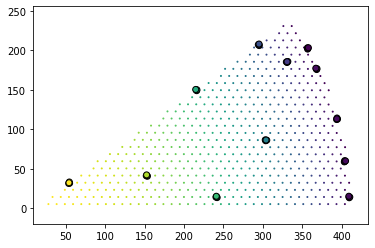

In [56]:
plt.scatter(D.x, D.y, c=D.z, s=1);
#plt.colorbar()
plt.scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], edgecolors='k');
plt.axis('equal');

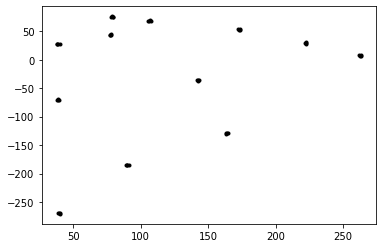

In [62]:
plt.plot(tp[:,0], tp[:,1], 'k.', label='POS')


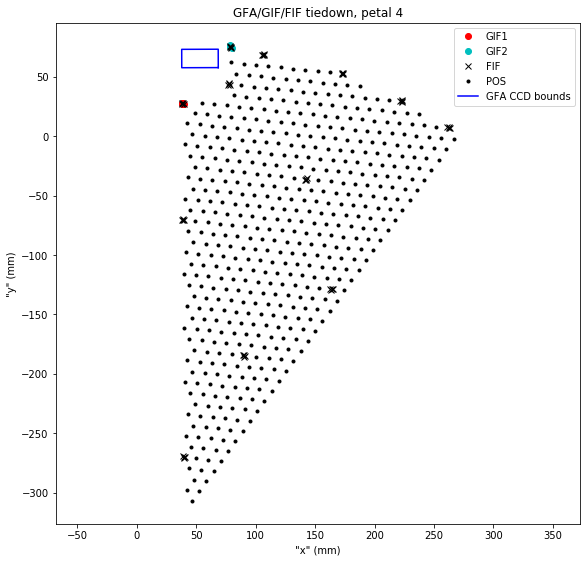

In [64]:
plt.figure(figsize=(8,8))
plt.clf()
plt.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)

P = D[D.device == 'POS']
vp = np.vstack((P.x, P.y)).T
tp = np.dot(R, (vp-vc).T).T + pc

# gfa size (mountain)
h,w = 1032, 2048
pixx = np.array([1, 1, w, w, 1])
pixy = np.array([1, h, h, 1, 1])
ccdx = t.mm_x_coeffs[0] + t.mm_x_coeffs[1]*pixx + t.mm_x_coeffs[2]*pixy
ccdy = t.mm_y_coeffs[0] + t.mm_y_coeffs[1]*pixx + t.mm_y_coeffs[2]*pixy

plt.plot(ph[:,0], ph[:,1], 'ro', label='GIF1')
plt.plot(pi[:,0], pi[:,1], 'co', label='GIF2')
plt.plot(th[:,0], th[:,1], 'kx', label='FIF');
plt.plot(tp[:,0], tp[:,1], 'k.', label='POS')
plt.plot(ccdx, ccdy, 'b-', label='GFA CCD bounds')
plt.legend()
plt.axis('equal');
plt.xlabel('"x" (mm)')
plt.ylabel('"y" (mm)')
plt.title('GFA/GIF/FIF tiedown, petal 4')
plt.savefig('/tmp/1.png')

In [48]:
Dfifs = D[D.device == 'FIF']
len(Dfifs)

10

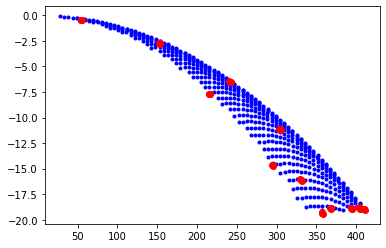

In [49]:
plt.plot(D.x, D.z, 'b.');
plt.plot(xyz[:,0], xyz[:,2], 'ro');

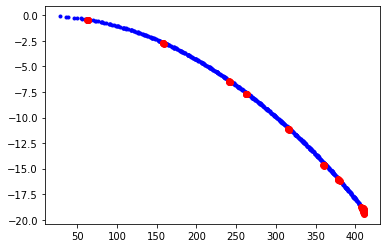

In [58]:
plt.plot(np.hypot(D.x, D.y), D.z, 'b.');
plt.plot(np.hypot(xyz[:,0],xyz[:,1]), xyz[:,2], 'ro');

In [50]:
I,J,d = match_xy(Dfifs.x, Dfifs.y, xyz[:,0], xyz[:,1], 10.)

In [51]:
len(Dfifs), len(xyz), len(I)

(10, 48, 40)

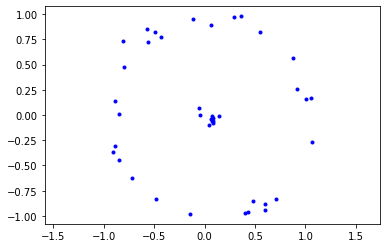

In [52]:
plt.plot(Dfifs.x[I] - xyz[J,0], Dfifs.y[I] - xyz[J,1], 'b.');
plt.axis('equal');

In [53]:
I,J,d = match_xy(Dfifs.x, Dfifs.y, xyz[:,0], xyz[:,1], 0.5)

In [54]:
len(I), len(Dfifs), len(xyz)

(10, 10, 48)

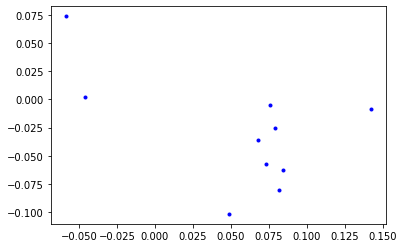

In [55]:
plt.plot(Dfifs.x[I] - xyz[J,0], Dfifs.y[I] - xyz[J,1], 'b.')

In [ ]:
permf = np.zeros(4, int)
for i in range(4):
    j = np.argmin(np.sqrt(np.sum((ph[i,:] - tf)**2, axis=1)))
    permf[i] = j

In [ ]:
ph - tf[permf]

In [ ]:
permg = np.zeros(4, int)
for i in range(4):
    j = np.argmin(np.sqrt(np.sum((pi[i,:] - tg)**2, axis=1)))
    permg[i] = j

In [ ]:
pi-tg[permg]

In [ ]:
N = 8
A = np.zeros((N,3))
A[:,0] = 1.
gfa_gif_x = np.append(t.gif_1_mm_x, t.gif_2_mm_x)
gfa_gif_y = np.append(t.gif_1_mm_y, t.gif_2_mm_y)
A[:,1] = gfa_gif_x
A[:,2] = gfa_gif_y

xx = np.append(GIF1.v1, GIF2.v1)
yy = np.append(GIF1.v2, GIF2.v2)
#xx = np.append(GIF2.v1, GIF1.v1)
#yy = np.append(GIF2.v2, GIF1.v2)

r = np.linalg.lstsq(A, xx, rcond=None)
cx = r[0]
r = np.linalg.lstsq(A, yy, rcond=None)
cy = r[0]

print(cx, cy)

fitx = cx[0] + cx[1]*gfa_gif_x + cx[2]*gfa_gif_y
fity = cy[0] + cy[1]*gfa_gif_x + cy[2]*gfa_gif_y

In [ ]:
plt.plot(xx, yy, 'b.')
plt.plot(fitx, fity, 'gx')